# Image classification
In this notebook we are solving an image classification problem using Densly coupled neural net. 

The data we are going to work with is the MNIST dataset which contains 70000 handwritten numbers evenly distributed between 0-9.


In [10]:
import tensorflow as tf
import numpy as np
#import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
#import pandas as pd
from sklearn.metrics import classification_report
# Some common filses used in laboration

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          fig_size=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
    else:
        cm = cm
    

    fig, ax = plt.subplots(figsize=(fig_size,fig_size))
    im = ax.imshow(cm,norm=LogNorm(), cmap=cmap,
                interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ylim=ax.get_ylim()
    ax.set(
        ylim=ylim,
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, 
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

import numpy as np
from matplotlib import pyplot as plt

def plot_errors(x_test, y_test, output,n_max=600):
    """ Function the reporting in a script in order to
    breake the script if it is estimated to take to long time"""
    n_not_corr = np.sum(output != y_test )
    n = int(np.ceil(np.sqrt(n_not_corr)))
    j = 0
    if n_not_corr > n_max:
        print('more then '+str(n_max),n**2)
        return
    f, ax = plt.subplots(n, n, figsize=(25, 25))
    ax = ax.flatten()
    
    for i in range(np.shape(output)[0]):
            if output[i]!=y_test[i]:
                ax[j].set_title(str(y_test[i]) + ' as ' + str(output[i]))
                ax[j].imshow(x_test[i,:,:,0], cmap='gray')
                ax[j].axis('off')
                j+=1
    for x in ax.ravel():
        x.axis("off")
    plt.subplots_adjust(bottom=-0.09, wspace=0.03)
    plt.show()

### Load the dataset
And take a first look of the dataset by looking at the shape which gives us an idaea of the structure and size. We also show the dataset distribution.

Shape before reshape: (60000, 28, 28)
Train data: (60000, 28, 28, 1)
Test data: (10000, 28, 28, 1)


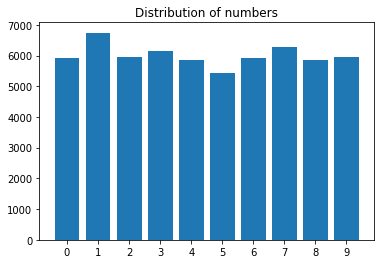

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Shape before reshape:',np.shape(x_train))
x_train = x_train.reshape(-1,28, 28, 1)   #Reshape for CNN !!
x_test = x_test.reshape(-1,28, 28, 1)     #The added dimension is to account for RRG images

##
print('Train data:',np.shape(x_train))
print('Test data:', np.shape(x_test))

y_count = np.bincount(y_train)
ii = np.nonzero(y_count)[0]
plt.bar(ii, y_count)
plt.xticks(ii)
plt.title('Distribution of numbers')
plt.show()

# Look at the dataset
It is always good to get a good overview of the dataset and explore it a little. In this case when images are going to be classified a good way is by looking at the images. If you don't trust the dataset you should go through the images and see if the classification is correct. 

Remember that there is a huge job done classifying all images. If you are going to do a classification task youself you first need to collect or create the images and then classify them. 

Note that some of the numbers are quite hard to classify even for the human eye. 

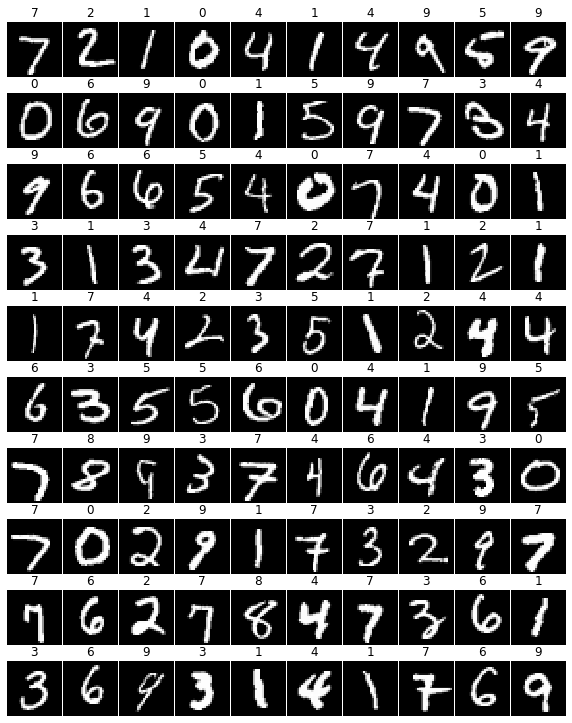

In [3]:
f,ax=plt.subplots(10, 10, figsize=(10, 10))
ax=ax.flatten()
for i in range(100):
    ax[i].imshow(x_test[i, :, :, 0], cmap='gray')
    ax[i].set_title(y_test[i])
[axi.set_axis_off() for axi in ax.ravel()]
plt.subplots_adjust(bottom=-0.09, wspace=0.03)
plt.show()

In [4]:
# Scale the dataset to have values between 0 and 1
if np.max(x_train)>1:
    x_train = x_train / 255.0
    x_test = x_test / 255.0
else:
    print('Already scaled once')

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history=model.fit(x_train, y_train, validation_data=(x_test,y_test),epochs=20,batch_size=512)
model.evaluate(x_test, y_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 25us/sample - loss: 0.8666 - acc: 0.7251 - val_loss: 0.2984 - val_acc: 0.9124
Epoch 2/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3750 - acc: 0.8878 - val_loss: 0.2181 - val_acc: 0.9356
Epoch 3/20
60000/60000 [==============================] - 1s 20us/sample - loss: 0.2981 - acc: 0.9121 - val_loss: 0.1835 - val_acc: 0.9449
Epoch 4/20
60000/60000 [==============================] - 1s 20us/sample - loss: 0.2577 - acc: 0.9240 - val_loss: 0.1616 - val_acc: 0.9497
Epoch 5/20
60000/60000 [==============================] - 1s 20us/sample - loss: 0.2329 - acc: 0.9306 - val_loss: 0.1465 - val_acc: 0.9556
Epoch 6/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.2151 - acc: 0.9358 - val_loss: 0.1353 - val_acc: 0.9593
Epoch 7/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.1991 - acc: 0.9406 - val_loss: 0.

[0.09172086160656763, 0.9713]

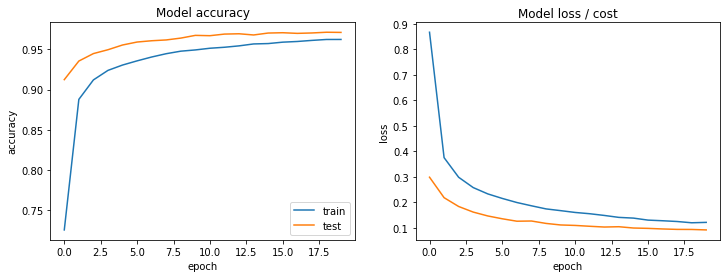

In [6]:
# summarize history for accuracy
f,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(history.history['acc'], label='train')
ax[0].plot(history.history['val_acc'], label='test')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()

# summarize history for loss
ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='test')
ax[1].set_title('Model loss / cost')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[0].legend()
plt.show()


# Evaluate the result
One way to evaluate the result is throug the confusion matrix.

10000/10000 [==============================] - 0s 12us/sample


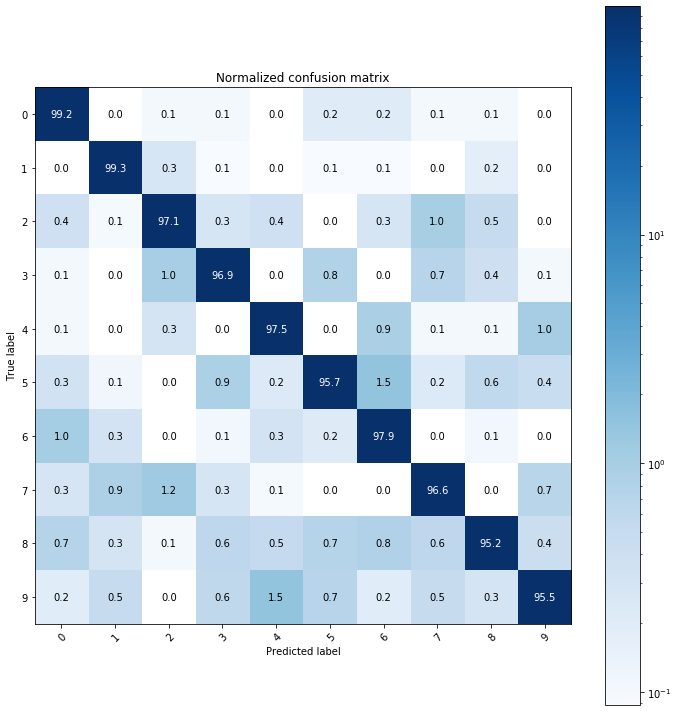

              precision    recall  f1-score   support

           0      0.969     0.992     0.980       980
           1      0.981     0.993     0.987      1135
           2      0.971     0.971     0.971      1032
           3      0.971     0.969     0.970      1010
           4      0.970     0.975     0.972       982
           5      0.969     0.957     0.963       892
           6      0.961     0.979     0.970       958
           7      0.969     0.966     0.967      1028
           8      0.977     0.952     0.964       974
           9      0.974     0.955     0.964      1009

    accuracy                          0.971     10000
   macro avg      0.971     0.971     0.971     10000
weighted avg      0.971     0.971     0.971     10000



In [12]:
class_names= np.unique(y_test)
predicted = model.predict_classes(x_test, verbose=1, batch_size=512)
plot_confusion_matrix(y_test, predicted, classes=class_names, normalize=True,
                      title='Normalized confusion matrix',fig_size=10)
plt.show()
# plot_confusion_matrix
print(classification_report(y_test, predicted, digits = 3))

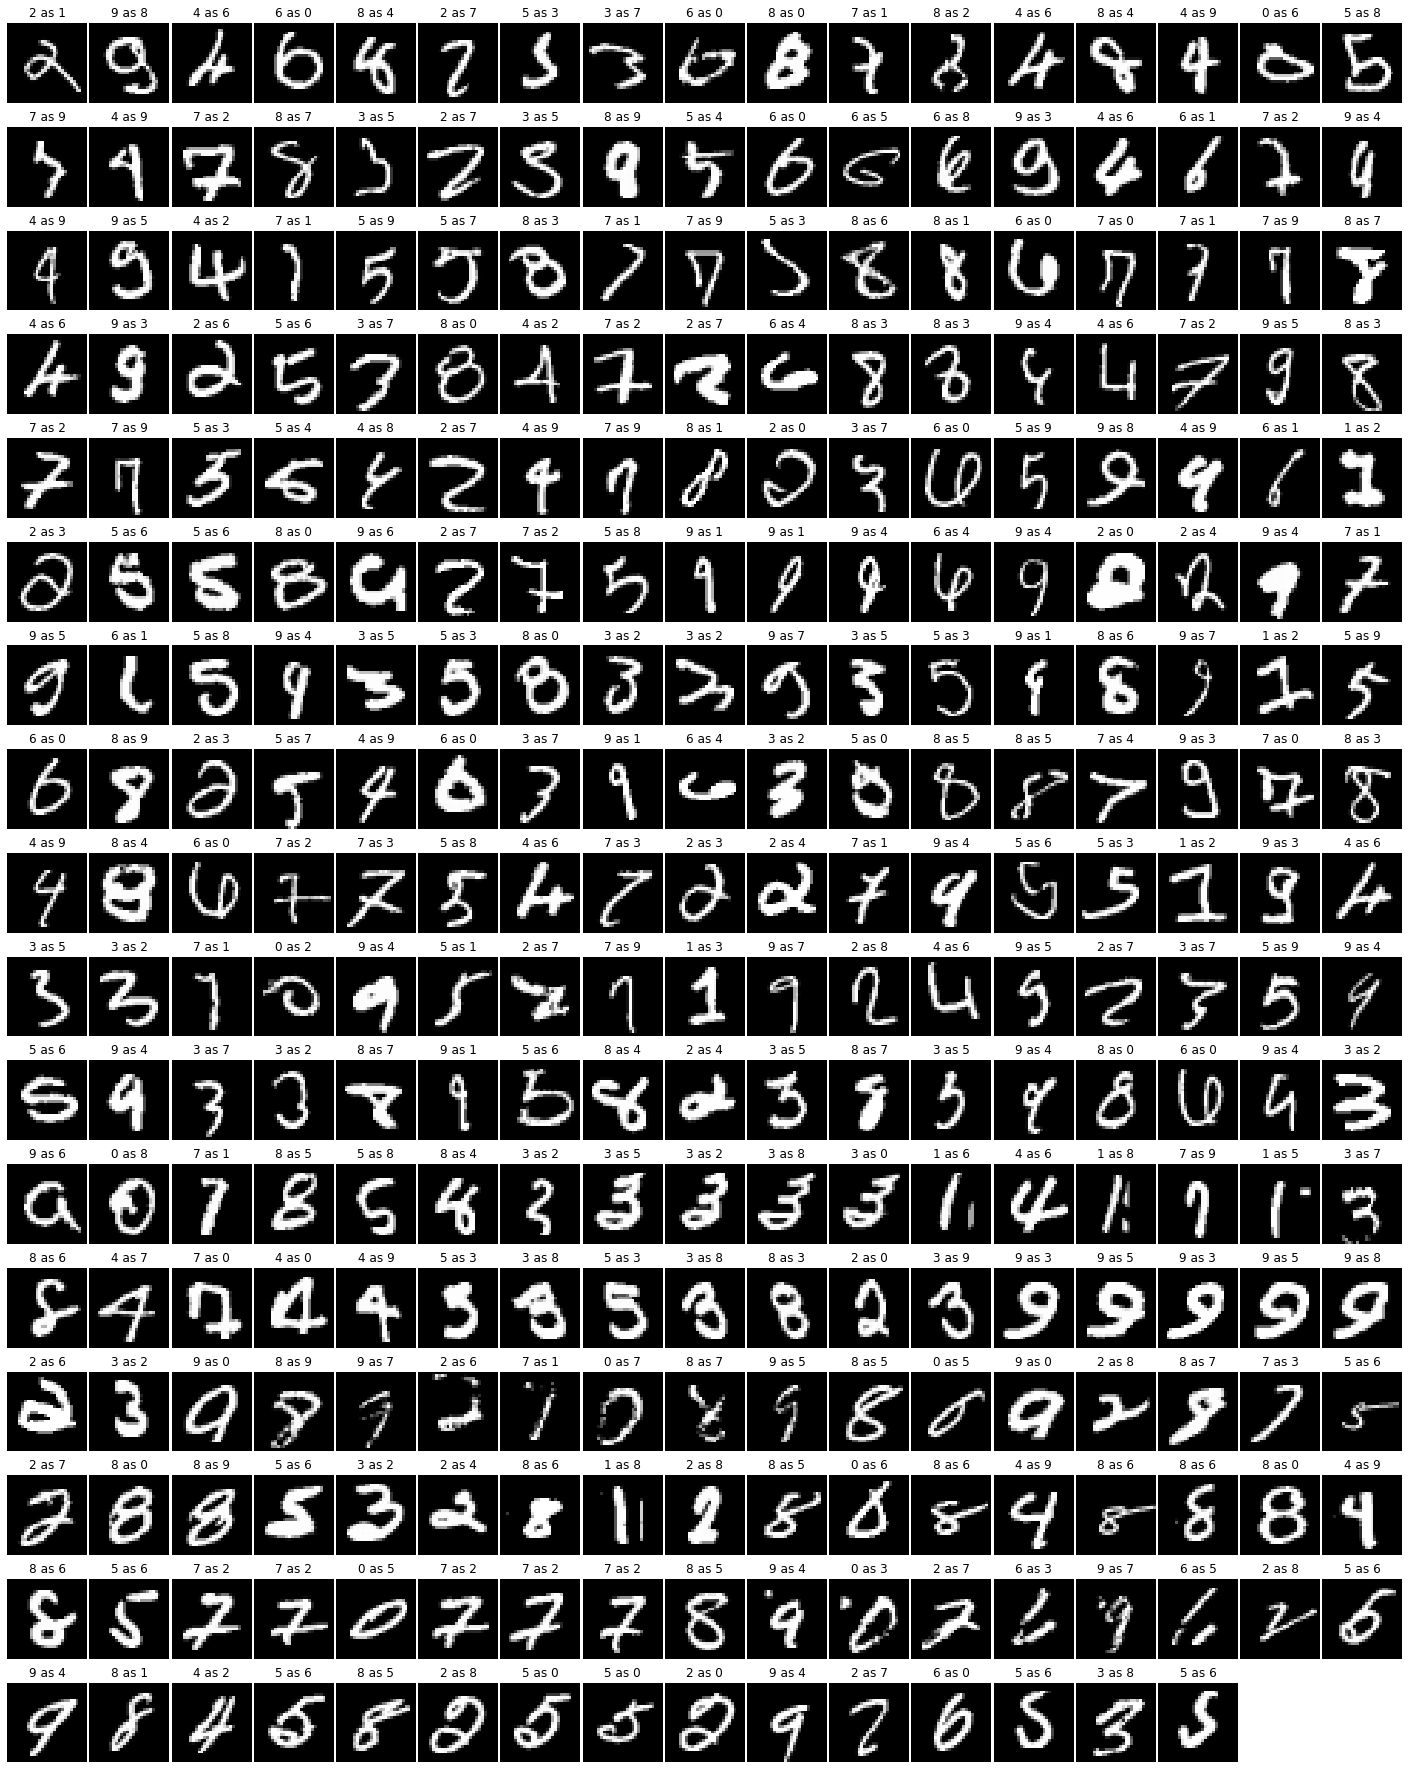

In [14]:
plot_errors(x_test, y_test, predicted, 600)

# Using a deeper net
We can experiment with different configurations of the artificial neural network to get some improvements. The parameters that can be modified within each layer are:
* Activation function (relu, sigmoid)
* Number of neuron in each layer (32,64,128,256)
* Fraction of Dropouts in each layer (0.1, 0.2, 0.3)

Resulting in $2*5*3=30$ combinations

Then we might want to evaluate the number of layers
* Number of layers (1, 2, 3, 5)



In [16]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy','acc'])

history1=model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5,batch_size=256)


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 32us/sample - loss: 0.5685 - accuracy: 0.8248 - acc: 0.8248 - val_loss: 0.1898 - val_accuracy: 0.9412 - val_acc: 0.9412
Epoch 2/5
60000/60000 [==============================] - 2s 26us/sample - loss: 0.2264 - accuracy: 0.9343 - acc: 0.9343 - val_loss: 0.1288 - val_accuracy: 0.9607 - val_acc: 0.9607
Epoch 3/5
60000/60000 [==============================] - 2s 25us/sample - loss: 0.1680 - accuracy: 0.9502 - acc: 0.9502 - val_loss: 0.1106 - val_accuracy: 0.9674 - val_acc: 0.9674
Epoch 4/5
60000/60000 [==============================] - 2s 25us/sample - loss: 0.1384 - accuracy: 0.9590 - acc: 0.9590 - val_loss: 0.0941 - val_accuracy: 0.9718 - val_acc: 0.9718
Epoch 5/5
60000/60000 [==============================] - 2s 25us/sample - loss: 0.1160 - accuracy: 0.9658 - acc: 0.9658 - val_loss: 0.0910 - val_accuracy: 0.9731 - val_acc: 0.9731


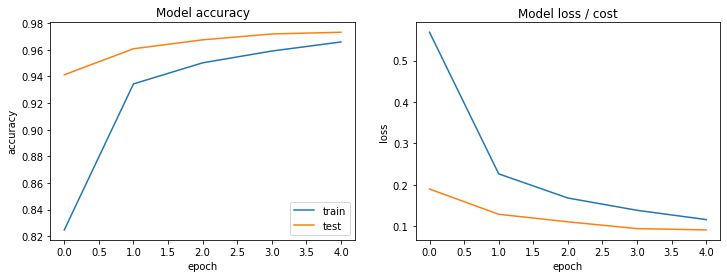

10000/10000 [==============================] - 0s 12us/sample


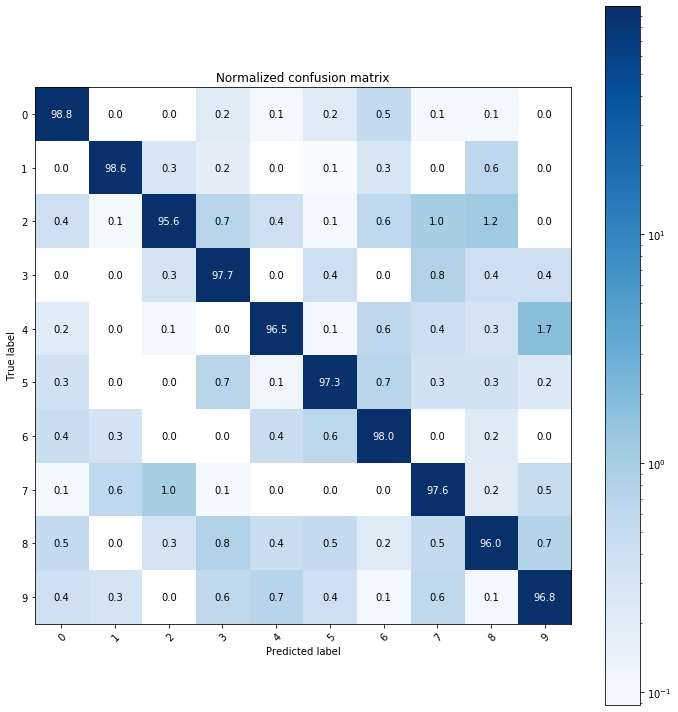

              precision    recall  f1-score   support

           0      0.977     0.988     0.982       980
           1      0.989     0.986     0.987      1135
           2      0.980     0.956     0.968      1032
           3      0.969     0.977     0.973      1010
           4      0.978     0.965     0.972       982
           5      0.973     0.973     0.973       892
           6      0.970     0.980     0.975       958
           7      0.964     0.976     0.970      1028
           8      0.964     0.960     0.962       974
           9      0.965     0.968     0.967      1009

    accuracy                          0.973     10000
   macro avg      0.973     0.973     0.973     10000
weighted avg      0.973     0.973     0.973     10000



In [21]:
# summarize history for accuracy
f,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(history1.history['acc'], label='train')
ax[0].plot(history1.history['val_acc'], label='test')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()

# summarize history for loss
ax[1].plot(history1.history['loss'], label='train')
ax[1].plot(history1.history['val_loss'], label='test')
ax[1].set_title('Model loss / cost')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[0].legend()
plt.show()

predicted1 = model1.predict_classes(x_test, verbose=1, batch_size=512)
###
plot_confusion_matrix(y_test, predicted1, classes=class_names, normalize=True,
                      title='Normalized confusion matrix',fig_size=10)
plt.show()
###
conf_mat1 = confusion_matrix(y_test.flatten(), predicted1)

print(classification_report(y_test, predicted1, digits=3))

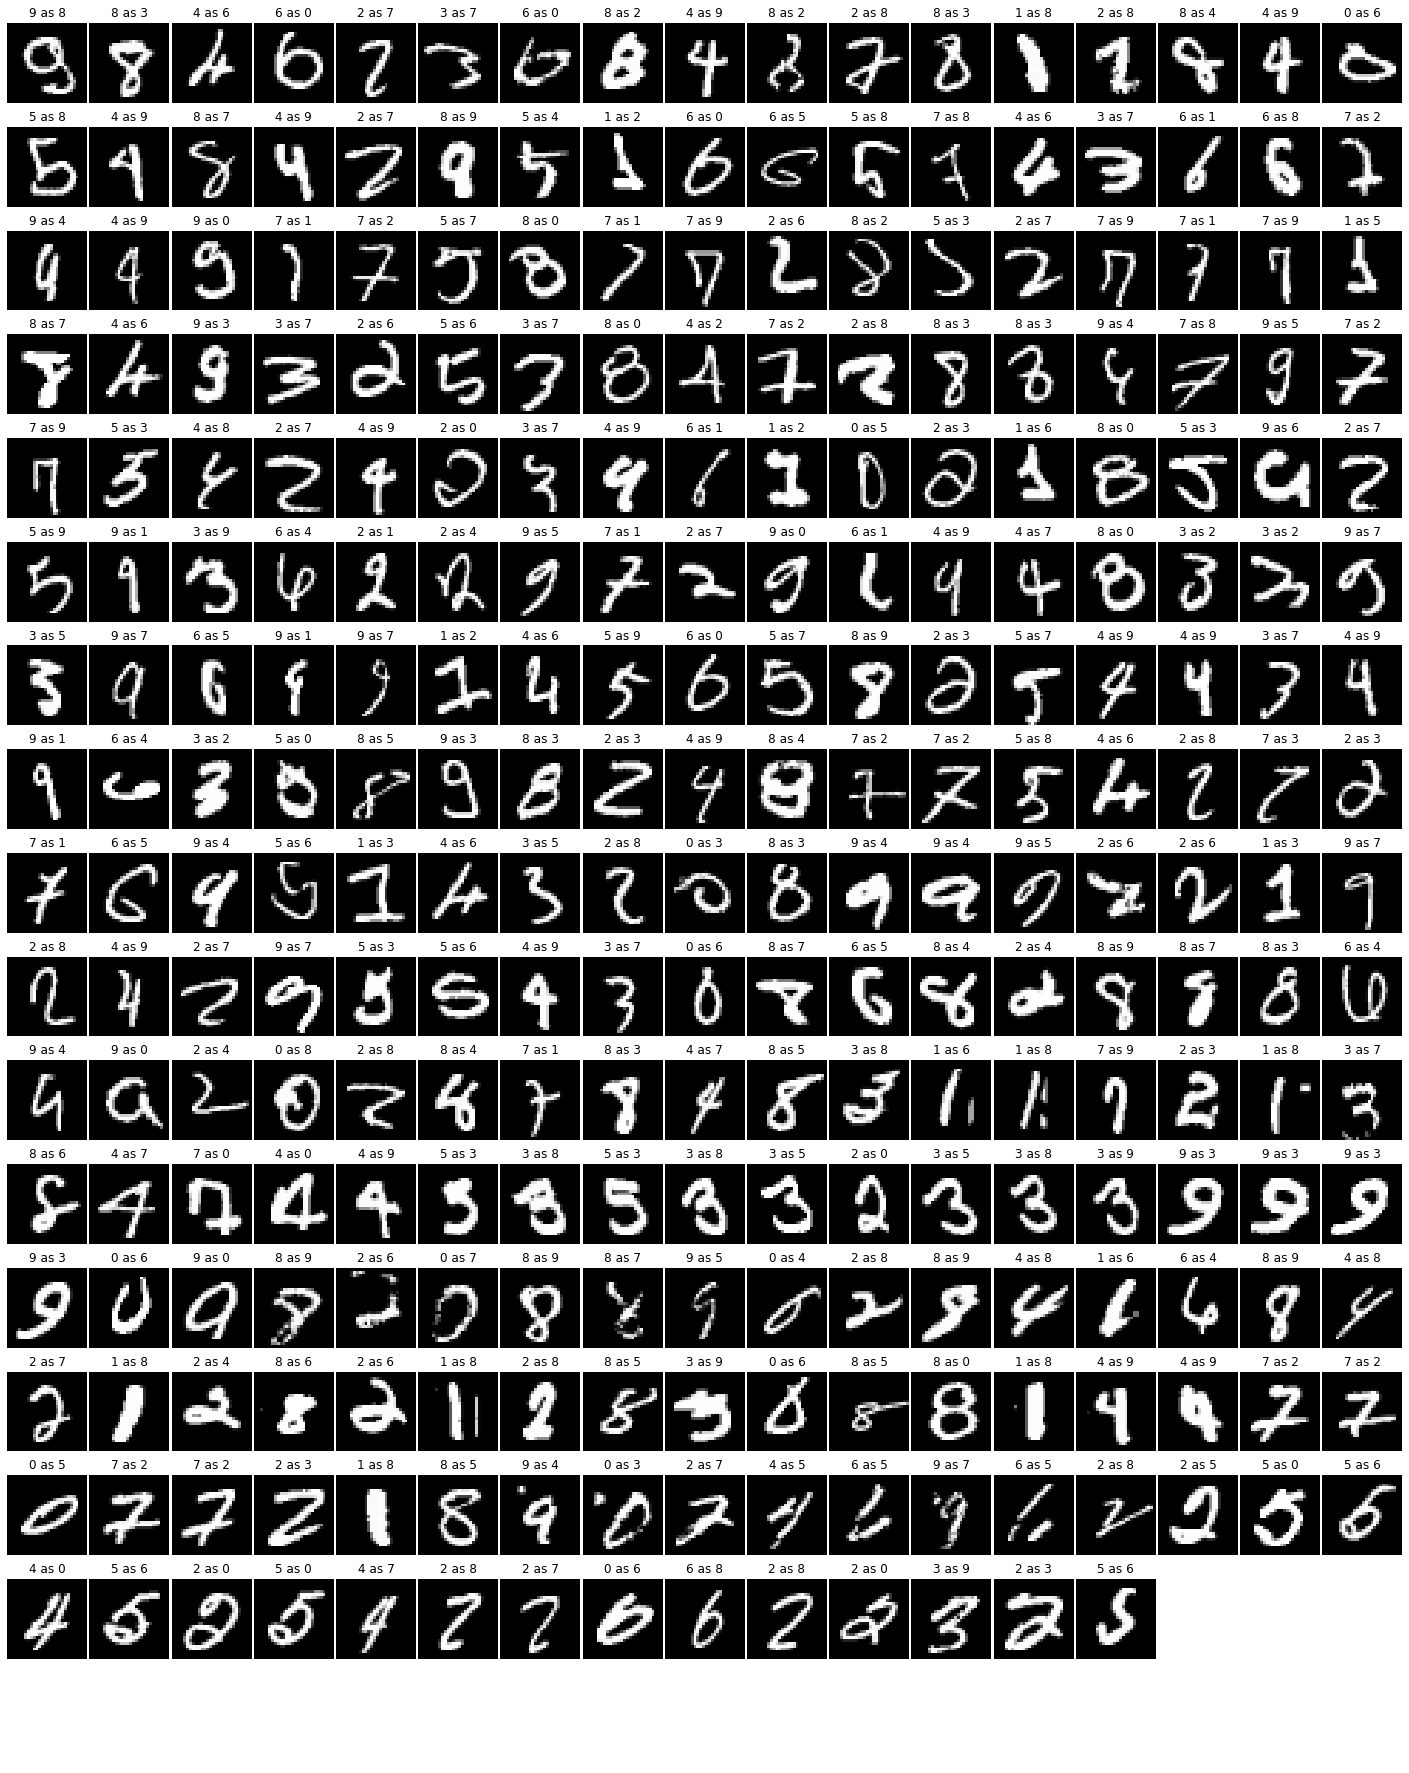

In [23]:
report.plot_errors(x_test, y_test, predicted1,600)

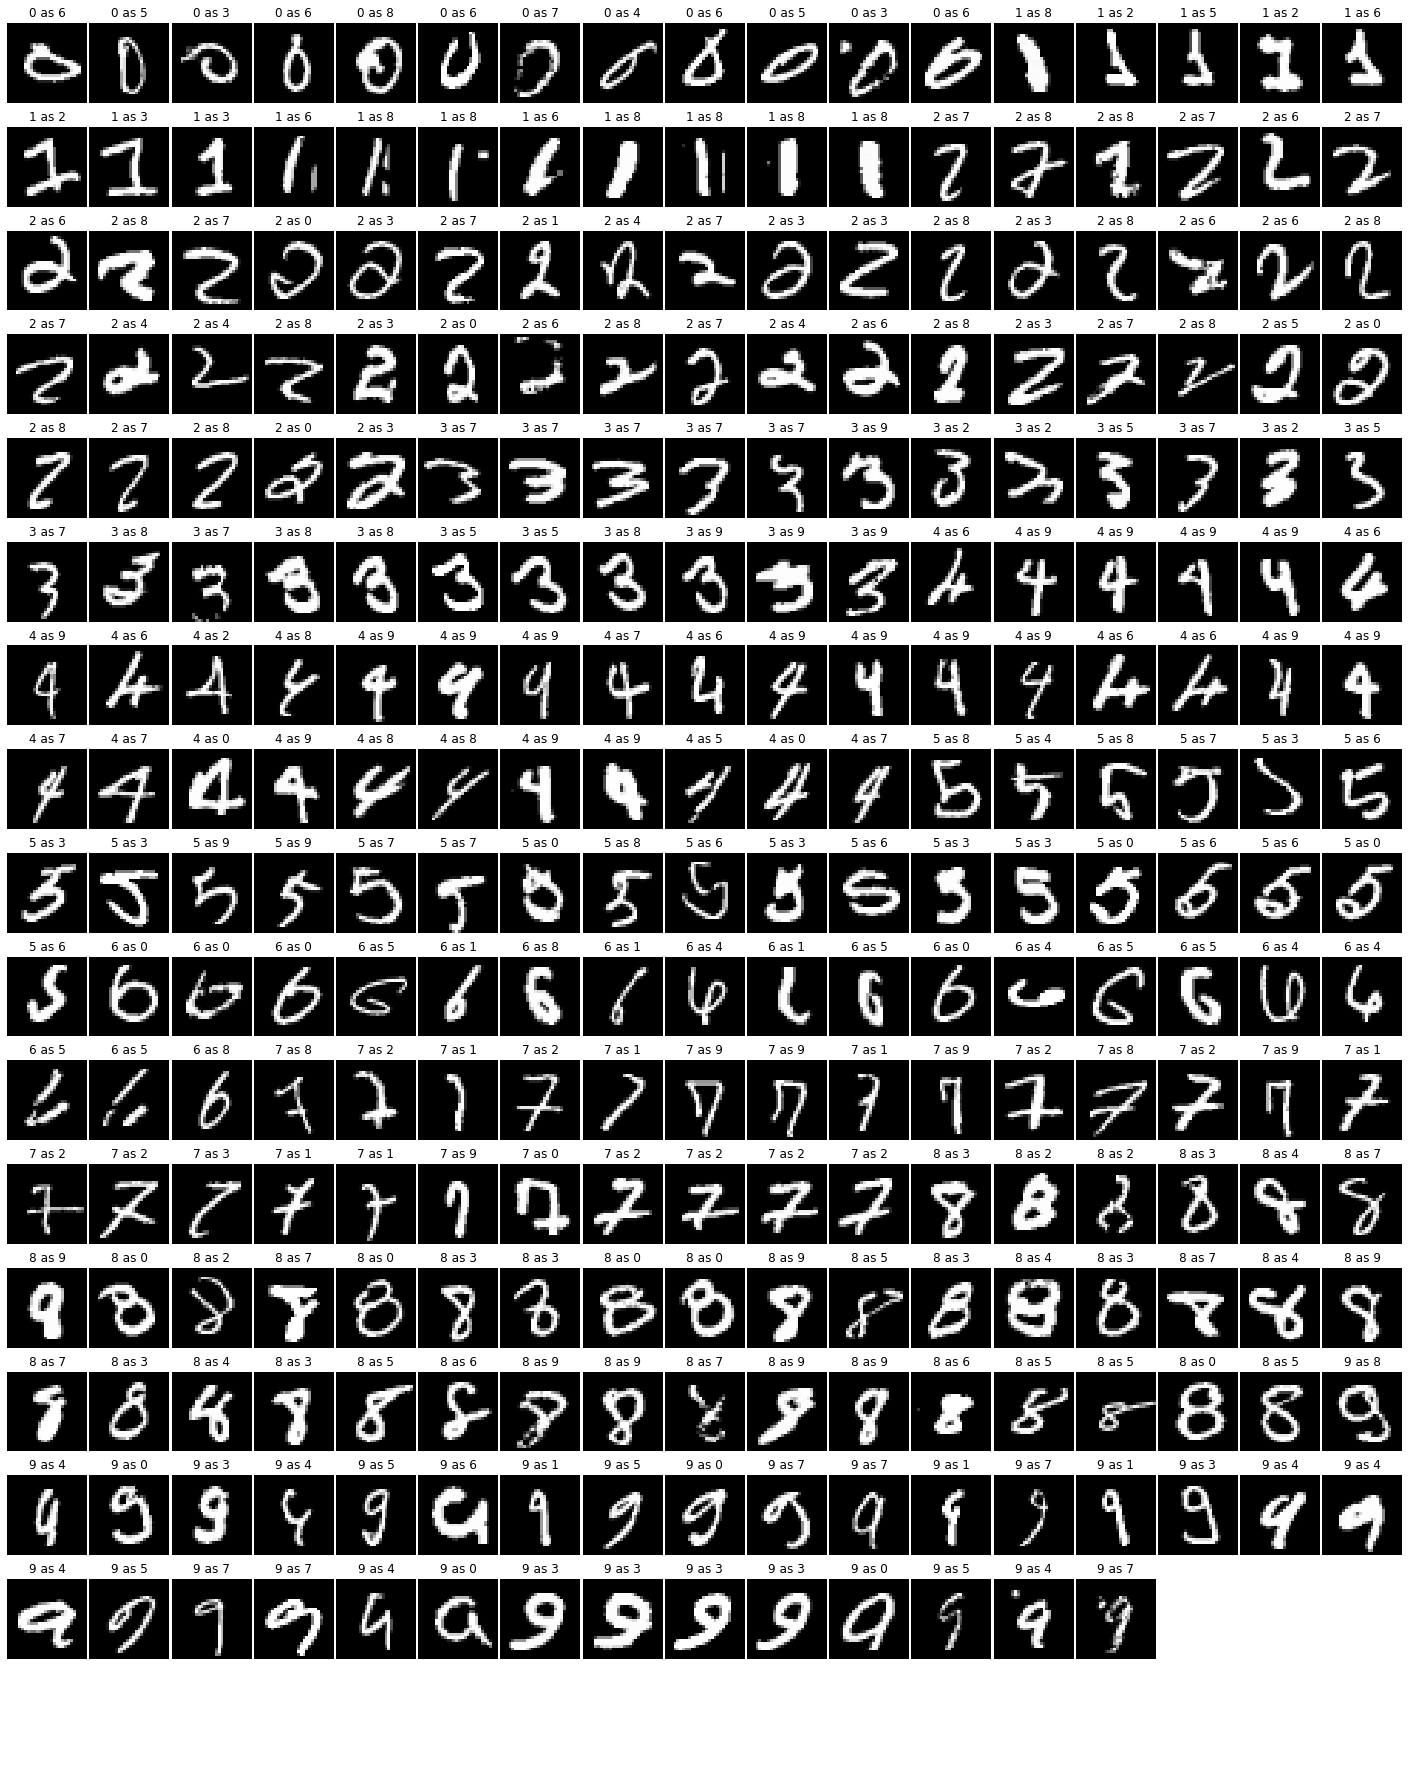

In [27]:
n_not_corr = np.sum(predicted1 != y_test )
n = int(np.ceil(np.sqrt(n_not_corr)))
j = 0
f, ax = plt.subplots(n, n, figsize=(25, 25))
ax = ax.flatten()

# Plot all wrongly predicted numbers in order...
for NUMBER in range(10):
    for i in range(np.shape(predicted1)[0]):
        if (predicted1[i]!=y_test[i]) & (y_test[i]==NUMBER):
                ax[j].set_title(str(y_test[i]) + ' as ' + str(predicted1[i]))
                ax[j].imshow(x_test[i, :, :,0], cmap='gray')
                ax[j].axis('off')
                j+=1
for x in ax.ravel():
    x.axis("off")
plt.subplots_adjust(bottom=-0.09, wspace=0.03)
plt.show()